In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.36 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


In [2]:
import torch
import numpy as np
from collections import deque, namedtuple
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from agent import MultiAgent
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
env_info = env.reset(train_mode=True)[brain_name]

In [5]:
# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

In [6]:
multi_agent = MultiAgent(state_size=state_size, action_size=action_size,n_agents=num_agents, random_seed=1)

In [8]:
def ddpg(n_episodes=30000, max_t=2000):
    all_scores = []
    scores_window = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        
        multi_agent.reset()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations           
        scores = np.zeros(num_agents)

        for i in range(max_t):
            actions = multi_agent.act(states)
            env_info = env.step(actions)[brain_name]
            rewards = env_info.rewards
            next_states = env_info.vector_observations
            dones = env_info.local_done

            multi_agent.step(states, actions, rewards, next_states, dones)

            scores += rewards
            states = next_states
                
        avg_score = np.mean(scores)
        scores_window.append(avg_score)
        all_scores.append(avg_score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-5, np.mean(scores_window)))
            torch.save(ma.ddpg_agents[0].actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(ma.ddpg_agents[0].critic_local.state_dict(), 'checkpoint_critic.pth')
            break 
            
    return all_scores

In [9]:
scores = ddpg()

Episode 100	Average Score: 2.33	Score: 2.951

Environment solved in 100 episodes!	Average Score: 2.33


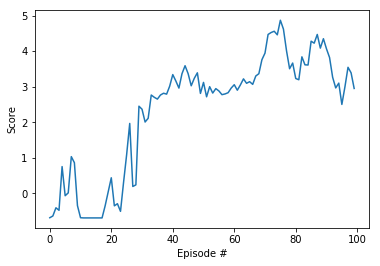

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
env.close()